In [34]:
# create BED-like entries of the linear ordering of phased barcodes in the original 10x alignment
import pysam
import cPickle as pickle
bam = '/hive/users/ifiddes/notch2nl_berkeley_data/E2del68/outs/phased_possorted_bam.bam'

In [13]:
bins = pickle.load(open('/hive/users/ifiddes/notch2nl_berkeley_data/E2del68/full-assembly/working/PhaseBarcodesStep/bins/clusters.p'))

In [14]:
ab_bins = [bins[1], bins[6], bins[7], bins[8]]

In [17]:
all_barcodes = set.union(*ab_bins)
barcode_dict = {1: bins[1], 6: bins[6], 7: bins[7], 8: bins[8]}

In [43]:
from collections import *
phased_alignments = defaultdict(lambda: defaultdict(list))
handle = pysam.Samfile(bam)
for rec in handle.fetch('chr1', 119482766, 149972386):
    if rec.is_supplementary or rec.is_secondary:
        continue
    try:
        tag = rec.get_tag('BX')
    except KeyError:
        continue
    if tag in all_barcodes:
        for b, c in barcode_dict.iteritems():
            if tag in c:
                phased_alignments[b][tag].append(rec)

In [59]:
# convert each to BED12
from tools.intervals import *
from tools.transcripts import *
phased_intervals = defaultdict(dict)
for b in phased_alignments:
    for tag, recs in phased_alignments[b].iteritems():
        intervals = []
        for rec in recs:
            if rec.mapping_quality >= 60:
                for block in rec.get_blocks():
                    intervals.append(ChromosomeInterval('chr1', block[0], block[1], '+'))
        intervals = gap_merge_intervals(intervals, 0)
        if len(intervals) > 0:
            phased_intervals[b][tag] = intervals_to_bed(intervals, name=tag)

In [60]:
with open('test.bed', 'w') as outf:
    outf.write('track name=test visibility=squish\n')
    for rec in phased_intervals[b].itervalues():
        outf.write('\t'.join(rec.get_bed()) + '\n')

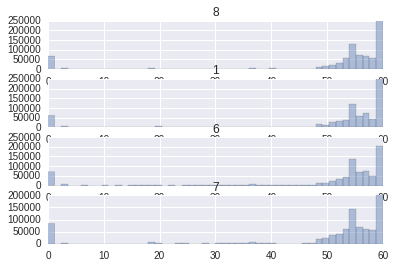

In [48]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=4)
for i, b in enumerate(phased_alignments):
    scores = []
    for tag in phased_alignments[b]:
        for rec in phased_alignments[b][tag]:
            scores.append(rec.mapping_quality)
    g = sns.distplot(scores, ax=axes[i], kde=False, norm_hist=False)
    g.set_title(b)